# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.3


In [2]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [3]:
test = pd.read_csv("../preprocessed_data/custom_test_0.1_imbalanced.csv")
print("Test shape:", test.shape )

test_balanced = pd.read_csv("../preprocessed_data/custom_test_0.1_balanced.csv")
print("Balanced Test shape:", test_balanced.shape )

train = pd.read_csv("../preprocessed_data/custom_train_0.9_balanced.csv")
print("Train shape:",train.shape)

Test shape: (1057, 60)
Balanced Test shape: (2880, 60)
Train shape: (25920, 60)


In [4]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

# Let's substract 0.1 instead of 0.2 from the Kaplan Meier survival scores 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


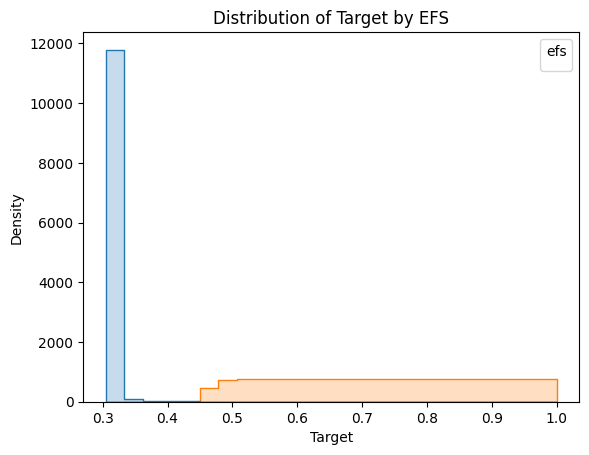

In [5]:
SUBTRACT_KP_SCORE = 0.15

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

test['label'] = transform_survival_probability(test, time_col='efs_time', event_col='efs')
test.loc[test['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook
test_balanced['label'] = transform_survival_probability(test_balanced, time_col='efs_time', event_col='efs')
test_balanced.loc[test_balanced['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

# Let's convert year_hct to year_hct_from_baseline to avoid a big difference in scale

In [6]:
MIN_YEAR = train['year_hct'].min() # 2008
train['year_hct_relative'] = train['year_hct'] - MIN_YEAR
train.drop(columns=['year_hct'], inplace=True)

test['year_hct_relative'] = test['year_hct'] - MIN_YEAR
test.drop(columns=['year_hct'], inplace=True)   

test_balanced['year_hct_relative'] = test_balanced['year_hct'] - MIN_YEAR   
test_balanced.drop(columns=['year_hct'], inplace=True)  


In [7]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'year_hct_relative']


In [8]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        test_balanced[c] = test_balanced[c].fillna("NAN")

In [9]:
combined = pd.concat([train, test, test_balanced], axis=0, ignore_index=True)

print("The CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):len(train) + len(test)].reset_index(drop=True).copy()
test_balanced = combined.iloc[len(train) + len(test):].reset_index(drop=True).copy()


The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [10]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [11]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# DeepSeek's adversarial training for group invariance and group DPO

In [74]:
# Prepare out‑of‑fold DataFrame to hold predictions and metadata
oof_xgb = train[['kfold', 'ID', 'efs', 'efs_time', 'label', 'race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame({'feature': FEATURES})
metric_df = []

# Add these parameters at the top
N_ITERATIONS = 3  # Number of adversarial+DRO updates
ADVERSARY_STRENGTH = 0.7  # Higher = more race invariance
DRO_STRENGTH = 0.3  # Higher = more focus on worst groups

# Initialize sample weights and group weights
sample_weights = np.ones(len(train))
group_weights = {group: 1.0 for group in train['race_group'].unique()}

# Modified training loop with adversarial+DRO
for iteration in range(N_ITERATIONS):
    print(f"\n=== Adversarial+DRO Iteration {iteration+1}/{N_ITERATIONS} ===")
    
    oof_xgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
    oof_xgb['prediction'] = 0.0
    metric_df = []
    
    # Store adversary training data across folds
    all_train_indices = []  # Store indices of training data for each fold
    all_leaf_indices = []
    all_races = []
    
    for fold in range(skf.n_splits):
        print(f"\nFold {fold+1}/{skf.n_splits}")
        
        x_train = train[train.kfold != fold].copy()
        x_valid = train[train.kfold == fold].copy()

        y_train = x_train['label']
        y_valid = x_valid['label']

        # Store training indices for this fold
        all_train_indices.append(x_train.index)
        
        # define two extra dataframe for the custom metric
        ds_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
        ds_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)
        
        # Get current sample weights for training data
        train_weights = sample_weights[x_train.index]

        # Train model with current weights
        clf = XGBRegressor(
            tree_method="hist",
            max_depth=3,
            colsample_bytree=0.5, 
            subsample=0.8, 
            n_estimators=10000,  
            learning_rate=0.03,
            early_stopping_rounds=100,
            objective='reg:squarederror',
            enable_categorical=True,
            min_child_weight=5,
            eval_metric=CIndexMetric_XGB,
            disable_default_eval_metric=True
        )
        
        clf.fit(
            x_train[FEATURES], y_train,
            sample_weight=train_weights,  # Apply current weights
            eval_set=[(x_valid[FEATURES], y_valid)],
            verbose=500
        )
        
        # Get leaf indices for adversarial training
        # booster = clf.get_booster()
        num_trees = 1300 if iteration == 0 else 1100 #booster.best_iteration
        leaf_indices = clf.get_booster().predict(
            xgb.DMatrix(x_train[FEATURES], enable_categorical=True),
            pred_leaf=True,
            iteration_range=(0, num_trees)  # Limit to the best number of trees
        )
        all_leaf_indices.append(leaf_indices)
        all_races.append(x_train['race_group'])
        
        # Store predictions
        preds_valid = clf.predict(x_valid[FEATURES])
        oof_xgb.loc[oof_xgb.kfold==fold, 'prediction'] = preds_valid
        
        clf.save_model(f"xgb/xgb_model_deepseek_adversarial_dro_{iteration}_{fold}.bin")

        # Calculate fold metrics
        y_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy()
        y_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy()
        _, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
        metric_df.append(metric_dict)
    
    # After all folds: Update weights -------------------------------------------------
    
    # 1. Adversarial weight update
    # Train adversary on leaf indices from all folds
    adversary = XGBClassifier(
        tree_method='hist',
        max_depth=3,
        enable_categorical=True,
        n_estimators=200
    )
    
    # Prepare adversarial training data
    adv_features = np.concatenate(all_leaf_indices)
    adv_target = pd.concat(all_races).reset_index(drop=True)
    
    # Encode race labels into numeric values
    label_encoder = LabelEncoder()
    adv_target_encoded = label_encoder.fit_transform(adv_target)

    # Train race predictor
    adversary.fit(adv_features, adv_target_encoded)

    adversary.save_model(f"xgb/xgb_model_deepseek_adversary_{iteration}.bin")
    
    # Calculate race predictability
    race_probs = adversary.predict_proba(adv_features)
    correct_probs = race_probs[np.arange(len(adv_target)), adv_target.cat.codes]
    adv_weights = 1 / (correct_probs + 1e-8)  # Downweight predictable samples
    
    # Map back to original indices
    adv_weight_df = pd.DataFrame({
        'index': np.concatenate(all_train_indices),  # Use stored training indices
        'adv_weight': adv_weights
    })
    adv_weight_df = (
    adv_weight_df
    .groupby('index')['adv_weight'].mean()  # Aggregate duplicates (mean/sum)
    .reindex(train.index)                   # Align with original training data
    .fillna(1.0)                            # Fill missing values
    .rename('adv_weight')                   # Rename for clarity
    .to_frame()                             # Convert to DataFrame
    )


    # 2. Group DRO weight update
    # Calculate group performance from OOF predictions
    group_cindex = {}
    for group in train['race_group'].unique():
        mask = (oof_xgb['race_group'] == group)
        if mask.sum() > 0:
            cidx = concordance_index(
                oof_xgb.loc[mask, 'efs_time'],
                -oof_xgb.loc[mask, 'prediction'],
                oof_xgb.loc[mask, 'efs']
            )
            group_cindex[group] = cidx
    
    # Calculate group weights inversely proportional to performance
    min_cindex = min(group_cindex.values())
    group_weights = {
        group: (min_cindex / (cidx + 1e-8)) * DRO_STRENGTH
        for group, cidx in group_cindex.items()
    }
    
    # 3. Combine weights
    sample_weights = (
        adv_weight_df['adv_weight'].values * ADVERSARY_STRENGTH +
        train['race_group'].map(group_weights).astype(float) * DRO_STRENGTH
    )
    sample_weights = sample_weights / sample_weights.mean()  # Normalize

# Final training with updated weights -------------------------------------------------
print("\n=== Final Training ===")
display_overall(pd.DataFrame(metric_df))



=== Adversarial+DRO Iteration 1/3 ===

Fold 1/5
[0]	validation_0-CIndexMetric_XGB:-0.58985
[500]	validation_0-CIndexMetric_XGB:-0.66670
[1000]	validation_0-CIndexMetric_XGB:-0.67257
[1300]	validation_0-CIndexMetric_XGB:-0.67365
# c-index=0.6739, mean=0.6876 std=0.0137

Fold 2/5
[0]	validation_0-CIndexMetric_XGB:-0.59093
[500]	validation_0-CIndexMetric_XGB:-0.66839
[1000]	validation_0-CIndexMetric_XGB:-0.67378
[1500]	validation_0-CIndexMetric_XGB:-0.67550
[1563]	validation_0-CIndexMetric_XGB:-0.67550
# c-index=0.6758, mean=0.6910 std=0.0152

Fold 3/5
[0]	validation_0-CIndexMetric_XGB:-0.59818
[500]	validation_0-CIndexMetric_XGB:-0.67551
[1000]	validation_0-CIndexMetric_XGB:-0.67875
[1387]	validation_0-CIndexMetric_XGB:-0.67932
# c-index=0.6795, mean=0.6855 std=0.0060

Fold 4/5
[0]	validation_0-CIndexMetric_XGB:-0.59214
[500]	validation_0-CIndexMetric_XGB:-0.66485
[1000]	validation_0-CIndexMetric_XGB:-0.66996
[1387]	validation_0-CIndexMetric_XGB:-0.67055
# c-index=0.6711, mean=0.6832 st

XGBoostError: [18:24:14] /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.h:123: Check failed: end <= model.BoostedRounds() (1100 vs. 1023) : Out of range for tree layers.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013f7f8428 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013f9ceb3c xgboost::gbm::detail::LayerToTree(xgboost::gbm::GBTreeModel const&, int, int) + 340
  [bt] (2) 3   libxgboost.dylib                    0x000000013f9c7234 xgboost::gbm::GBTree::PredictLeaf(xgboost::DMatrix*, xgboost::HostDeviceVector<float>*, unsigned int, unsigned int) + 56
  [bt] (3) 4   libxgboost.dylib                    0x000000013f9e4810 xgboost::LearnerImpl::Predict(std::__1::shared_ptr<xgboost::DMatrix>, bool, xgboost::HostDeviceVector<float>*, int, int, bool, bool, bool, bool, bool) + 460
  [bt] (4) 5   libxgboost.dylib                    0x000000013f879058 XGBoosterPredictFromDMatrix + 864
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b0c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000103b09834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-38-darwin.so        0x0000000103ae40ac _ctypes_callproc + 856
  [bt] (8) 9   _ctypes.cpython-38-darwin.so        0x0000000103ade4e4 PyCFuncPtr_call + 228



In [39]:

def evaluate_test_set(test_set, model_prefix, skf, FEATURES, custom_score, dataset_name="test set"):
    """
    Evaluate the model on a given test set (imbalanced or balanced).
    
    Parameters:
        test_set (pd.DataFrame): The test set to evaluate.
        model_prefix (str): Prefix for the saved model filenames.
        skf (StratifiedKFold): Cross-validation object to determine the number of folds.
        FEATURES (list): List of feature columns.
        custom_score (function): Function to compute custom evaluation metric.
        dataset_name (str): Name of the dataset for logging purposes.
    
    Returns:
        None (prints evaluation results)
    """
    print(f"Evaluating on {dataset_name}...")

    # Ensure the test set has the required feature columns
    if not set(FEATURES).issubset(test_set.columns):
        raise ValueError(f"{dataset_name} does not have all required feature columns.")

    # Initialize an array to accumulate predictions from each fold
    test_predictions = np.zeros(len(test_set))

    # Initialize a dictionary to store the evaluation metric for each fold
    metric_df = []

    # Loop over folds, load each saved model, and predict on the test set
    for fold in range(skf.n_splits):
        model_filename = f"xgb/{model_prefix}_{fold}.bin"
        clf = XGBRegressor()  # We only use this to load the saved booster
        clf.load_model(model_filename)
        fold_pred = clf.predict(test_set[FEATURES])
        test_set[f'prediction_{fold}'] = fold_pred

        # If labels exist, compute the custom metric for this fold
        if "label" in test_set.columns:
            y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
            y_pred_test = test_set[["ID", f"prediction_{fold}"]].copy().reset_index(drop=True)
            m, metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label=f"prediction_{fold}")
            print(f"{dataset_name} evaluation metric for fold {fold}:", metric_dict)
            metric_df.append(metric_dict)

        test_predictions += fold_pred

    # Average the predictions across folds
    test_predictions /= skf.n_splits
    test_set['ensemble_prediction'] = test_predictions

    print('\nENSEMBLE:')
    # If labels exist, compute the custom metric for an ensemble
    if "label" in test_set.columns:
        y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
        y_pred_test = test_set[["ID", "ensemble_prediction"]].copy().reset_index(drop=True)
        m, ensemble_metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label="ensemble_prediction")
        print(f"{dataset_name} evaluation metric:", metric_dict)
    else:
        print(f"{dataset_name} predictions computed. No labels available for evaluation.")
    return ensemble_metric_dict, metric_df


# Evaluation on full test set

## upweight minority and ignore white

In [40]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, 
                                                                         "xgb_model_upweight_minority_ignore_white", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6546, mean=0.6657 std=0.0111
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6852392464534963, 'Asian': 0.6699527924558063, 'Black or African-American': 0.6523944502461584, 'More than one race': 0.6659624603883968, 'Native Hawaiian or other Pacific Islander': 0.6529193004271585, 'White': 0.6679261620813162}
# c-index=0.6534, mean=0.6671 std=0.0137
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6915568124800437, 'Asian': 0.6676205820385998, 'Black or African-American': 0.6535666332772107, 'More than one race': 0.6682608039559368, 'Native Hawaiian or other Pacific Islander': 0.6493270238218599, 'White': 0.6720588814106349}
# c-index=0.6583, mean=0.6680 std=0.0096
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6834032750992108, 'Asian': 0.6704935948713904, 'Black or African-American': 0.657019245114128, 'More than one race': 

In [41]:
display_overall(pd.DataFrame(balanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6852,0.6916,0.6834,0.6868,0.6943,0.6883
Asian,0.6700,0.6676,0.6705,0.6671,0.6692,0.6689
Black or African-American,0.6524,0.6536,0.6570,0.6477,0.6534,0.6528
More than one race,0.6660,0.6683,0.6657,0.6639,0.6691,0.6666
Native Hawaiian or other Pacific Islander,0.6529,0.6493,0.6562,0.6562,0.6527,0.6535
White,0.6679,0.6721,0.6750,0.6706,0.6701,0.6711
mean,0.666,0.667,0.668,0.665,0.668,0.667
std,0.011,0.014,0.010,0.012,0.014,0.012
score,0.655,0.653,0.658,0.653,0.654,0.655


## upweight minority

In [43]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, 
                                                                         "xgb_model_downweight_majority", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6552, mean=0.6668 std=0.0116
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.687531359759157, 'Asian': 0.6699753258897889, 'Black or African-American': 0.6549519404957269, 'More than one race': 0.6631998049890306, 'Native Hawaiian or other Pacific Islander': 0.6531726019826604, 'White': 0.6718719250600228}
# c-index=0.6543, mean=0.6672 std=0.0129
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6906787392236464, 'Asian': 0.667361447547799, 'Black or African-American': 0.6551970333113105, 'More than one race': 0.6680634714274106, 'Native Hawaiian or other Pacific Islander': 0.6504323397004134, 'White': 0.6716062502459952}
# c-index=0.6554, mean=0.6666 std=0.0112
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6830383615381107, 'Asian': 0.6690401883795081, 'Black or African-American': 0.6528633234585793, 'More than one race': 0

# Evaluation on imbalanced test subset

## upweight minority ignore white

In [44]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, "xgb_model_upweight_minority_ignore_white", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5780, mean=0.6338 std=0.0558
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6842818428184282, 'Asian': 0.6410490307867731, 'Black or African-American': 0.6406561737973842, 'More than one race': 0.5137686860739575, 'Native Hawaiian or other Pacific Islander': 0.6549925484351714, 'White': 0.6679261620813162}
# c-index=0.5895, mean=0.6402 std=0.0507
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6907181571815718, 'Asian': 0.6474344355758267, 'Black or African-American': 0.6372940220202468, 'More than one race': 0.5334382376081825, 'Native Hawaiian or other Pacific Islander': 0.6602086438152012, 'White': 0.6720588814106349}
# c-index=0.5820, mean=0.6373 std=0.0553
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6747967479674797, 'Asian': 0.6419612314709237, 'Black or African-American': 0.6482302519766496, 'More than on

In [45]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6843,0.6907,0.6748,0.6870,0.6789,0.6831
Asian,0.6410,0.6474,0.6420,0.6481,0.6474,0.6452
Black or African-American,0.6407,0.6373,0.6482,0.6370,0.6411,0.6408
More than one race,0.5138,0.5334,0.5169,0.5161,0.5264,0.5213
Native Hawaiian or other Pacific Islander,0.6550,0.6602,0.6669,0.6721,0.6565,0.6621
White,0.6679,0.6721,0.6750,0.6706,0.6701,0.6711
mean,0.634,0.640,0.637,0.638,0.637,0.637
std,0.056,0.051,0.055,0.057,0.051,0.054
score,0.578,0.589,0.582,0.581,0.586,0.583


## upweight minority

In [46]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, 
                                                                             "xgb_model_downweight_majority", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5733, mean=0.6343 std=0.0609
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6832655826558266, 'Asian': 0.6483466362599772, 'Black or African-American': 0.6458656617158058, 'More than one race': 0.5011801730920535, 'Native Hawaiian or other Pacific Islander': 0.6549925484351714, 'White': 0.6718719250600228}
# c-index=0.5935, mean=0.6410 std=0.0475
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6876693766937669, 'Asian': 0.6501710376282782, 'Black or African-American': 0.6393999852213109, 'More than one race': 0.5405192761605035, 'Native Hawaiian or other Pacific Islander': 0.6564828614008942, 'White': 0.6716062502459952}
# c-index=0.5793, mean=0.6357 std=0.0564
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6744579945799458, 'Asian': 0.6433295324971494, 'Black or African-American': 0.6443877928027784, 'More than on

In [47]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6833,0.6877,0.6745,0.6941,0.6839,0.6847
Asian,0.6483,0.6502,0.6433,0.6481,0.6447,0.6469
Black or African-American,0.6459,0.6394,0.6444,0.6361,0.6425,0.6417
More than one race,0.5012,0.5405,0.5130,0.5161,0.5256,0.5193
Native Hawaiian or other Pacific Islander,0.6550,0.6565,0.6632,0.6468,0.6565,0.6556
White,0.6719,0.6716,0.6760,0.6709,0.6705,0.6722
mean,0.634,0.641,0.636,0.635,0.637,0.637
std,0.061,0.048,0.056,0.057,0.052,0.055
score,0.573,0.593,0.579,0.579,0.585,0.582


In [45]:
test['race_group'].value_counts(normalize=True)

race_group
White                                        0.456954
Black or African-American                    0.245033
Asian                                        0.108798
American Indian or Alaska Native             0.081362
More than one race                           0.053926
Native Hawaiian or other Pacific Islander    0.053926
Name: proportion, dtype: float64

In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")